## Assessing allelic bias in RADseq data

Can we identify 'bad' loci by looking at allelic bias in heterozygotes?

Within a *heterozygous* individual we can assess allelic bias at a specific locus with a binomial test.  The null hypothesis is that each allelic sequence is equally likely. The p value represents the likelihood of a bias at least as big as observed under the null. Notice this is a two-tailed test.

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import numpy as np
import os.path
from IPython.core.pylabtools import figsize

In [2]:
%matplotlib inline

In [3]:
sns.set_style("white")

### Create file of allelic depths

In [4]:
from  vcf_to_depth import vcf_to_allele_depth

In [5]:
vcf_file = os.path.join('..', 'data', 'chinook.bay_pops.vcf.gz')
depths_file = os.path.join('..', 'data', 'chinook.bay_pops.depths')

In [6]:
vcf_to_allele_depth(vcf_file=vcf_file, out_file = depths_file)

skipped 9 header lines
found 192 individuals


In [7]:
depths = pd.read_csv(depths_file, sep = '\t', header = None)
depths.columns = ['contig', 'pos', 'locus_ID', 'depth_a' , 'depth_b', 'ratio', 'num_hets']
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets
0,un,44,10,1181,1013,0.538286,112
1,un,65,11,69,124,0.357513,7
2,un,17,14,36,60,0.375000,5
3,un,69,15,3746,2752,0.576485,184
4,un,73,17,136,130,0.511278,24


In [8]:
depths['total_depth'] = depths['depth_a'] + depths['depth_b']
depths['depth_per_het'] = depths['total_depth']/[np.float(xx) for xx in depths['num_hets']]
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het
0,un,44,10,1181,1013,0.538286,112,2194,19.589286
1,un,65,11,69,124,0.357513,7,193,27.571429
2,un,17,14,36,60,0.375000,5,96,19.200000
3,un,69,15,3746,2752,0.576485,184,6498,35.315217
4,un,73,17,136,130,0.511278,24,266,11.083333


### Read in file of giving duplicate status (based on map):
   - 0 = unknown
   - 1 = non-duplicated
   - 2 = duplicated

In [9]:
duplicate_status = pd.read_csv(os.path.join('..', 'data', 'chinook_DuplicateStatus.txt'), sep = '\t', header = 0)
duplicate_status.columns = ['locus_ID', 'Duplicate']
duplicate_status.head()

,locus_ID,Duplicate
0,85492,0
1,60449,0
2,44557,0
3,23753,1
4,11439,0


In [10]:
depths = pd.merge(depths, duplicate_status)

In [11]:
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0
1,un,65,11,69,124,0.357513,7,193,27.571429,0
2,un,17,14,36,60,0.375000,5,96,19.200000,1
3,un,69,15,3746,2752,0.576485,184,6498,35.315217,2
4,un,73,17,136,130,0.511278,24,266,11.083333,0


## Subset the loci based on various filters

In [12]:
filter_sets = pd.read_csv(os.path.join('..', 'data', 'chinook_FilteredLoci.txt'), '\t', header = 0)

filter_sets.head()

,locus_ID,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,85492,1,1,0,0,0,0,0
1,60449,1,1,1,0,0,0,0
2,44557,1,1,1,1,0,1,0
3,23753,1,1,1,0,0,0,0
4,11439,1,1,1,0,1,0,0


In [13]:
depths = pd.merge(depths, filter_sets)

In [14]:
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0
1,un,65,11,69,124,0.357513,7,193,27.571429,0,1,1,1,1,0,1,0
2,un,17,14,36,60,0.375000,5,96,19.200000,1,1,1,1,1,1,1,1
3,un,69,15,3746,2752,0.576485,184,6498,35.315217,2,0,0,0,1,1,0,0
4,un,73,17,136,130,0.511278,24,266,11.083333,0,1,1,1,1,1,1,1


#### calculated the expected std deviation, based on the binomial distribution

In [15]:
depths['std'] = scipy.stats.binom(n = depths['total_depth'], p = .5).std()
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077
1,un,65,11,69,124,0.357513,7,193,27.571429,0,1,1,1,1,0,1,0,6.946222
2,un,17,14,36,60,0.375000,5,96,19.200000,1,1,1,1,1,1,1,1,4.898979
3,un,69,15,3746,2752,0.576485,184,6498,35.315217,2,0,0,0,1,1,0,0,40.305087
4,un,73,17,136,130,0.511278,24,266,11.083333,0,1,1,1,1,1,1,1,8.154753


#### Z-score based on that std deviation

In [16]:
depths['z'] = -(depths['total_depth']/2. - depths['depth_a'])/ depths['std']
depths.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077,3.586666
1,un,65,11,69,124,0.357513,7,193,27.571429,0,1,1,1,1,0,1,0,6.946222,-3.958987
2,un,17,14,36,60,0.375000,5,96,19.200000,1,1,1,1,1,1,1,1,4.898979,-2.449490
3,un,69,15,3746,2752,0.576485,184,6498,35.315217,2,0,0,0,1,1,0,0,40.305087,12.330950
4,un,73,17,136,130,0.511278,24,266,11.083333,0,1,1,1,1,1,1,1,8.154753,0.367884


Fraction of 'a' alleles

In [17]:
sum_a = sum(depths['depth_a'])
sum_b = sum(depths['depth_b'])
frac_a = np.float(sum_a)/(sum_a + sum_b)
print sum_a, sum_b, frac_a

12990700 11769408 0.524662493395


Highly significant!

In [18]:
p_value = scipy.stats.binom_test((sum_a, sum_b))
print(p_value)

1.58101006669e-322


## Remove high-coverage loci

In [19]:
depths = depths[depths['total_depth'] < 100000]

### Large difference in depth and z-score by duplicate status

In [20]:
depths.groupby('Duplicate')['z', 'depth_per_het'].mean()

,z,depth_per_het
Duplicate,,
0,1.132644,21.702411
1,0.134513,20.091329
2,9.291488,34.193086


### Plots

In [21]:
figsize(8,4)

Absolute allele count difference

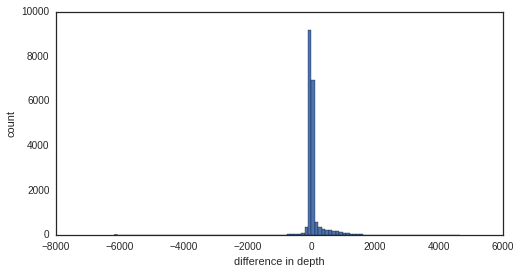

In [22]:
plt.hist(depths['depth_a']-depths['depth_b'], bins = 100)
plt.xlabel('difference in depth')
plt.ylabel('count')
plt.show()

Allelelic ratios

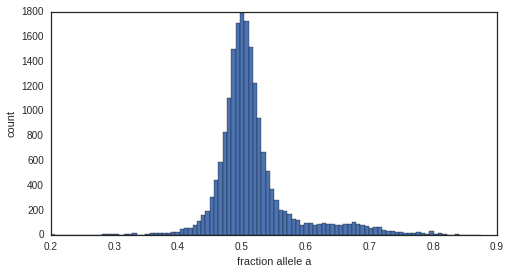

In [23]:
plt.hist(depths['ratio'], bins = 100)
plt.xlabel('fraction allele a')
plt.ylabel('count')
plt.show()

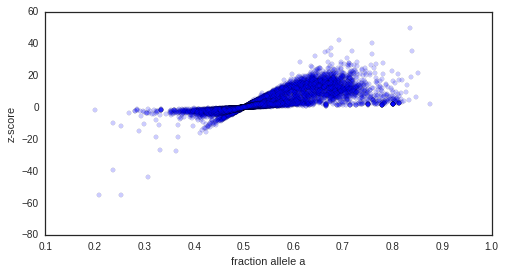

In [24]:
plt.scatter(depths['ratio'], depths['z'], alpha = .2)
plt.xlabel('fraction allele a')
plt.ylabel('z-score')
plt.show()

histogram of z-scores

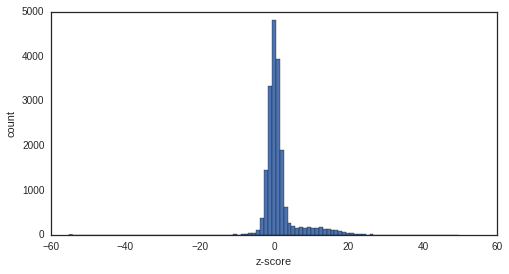

In [25]:
plt.hist(depths['z'], bins = 100)
plt.xlabel('z-score')
plt.ylabel('count')
plt.show()

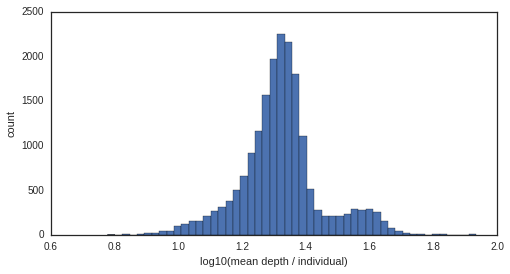

In [26]:
figsize(8,4)
#plt.xscale('log')
plt.hist(np.log10(depths['depth_per_het']), bins = 50)
plt.xlabel('log10(mean depth / individual) ')
plt.ylabel('count')
plt.show()

Higher depths leads to somewhat more bias

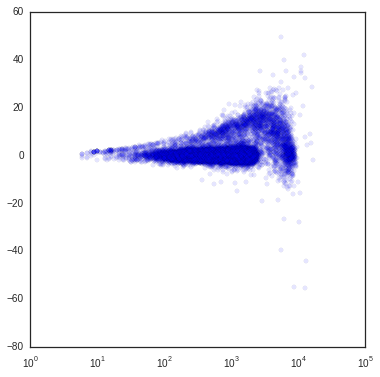

In [27]:
figsize(6,6)
plt.scatter(depths['total_depth'], depths['z'], alpha = .1)
plt.xscale('log')
plt.show()

In [28]:
non_dups = depths[depths['Duplicate']==1]
dups = depths[depths['Duplicate']==2]
unk = depths[depths['Duplicate']==0]

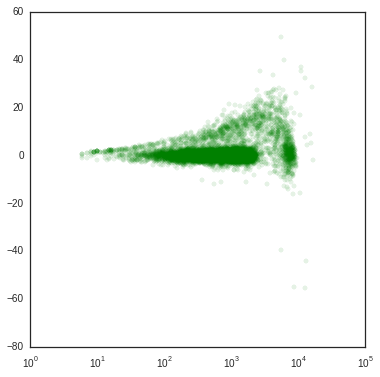

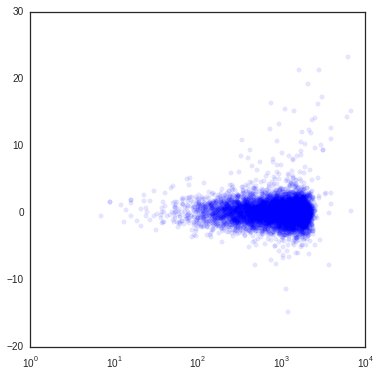

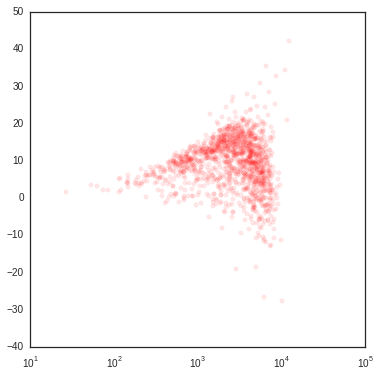

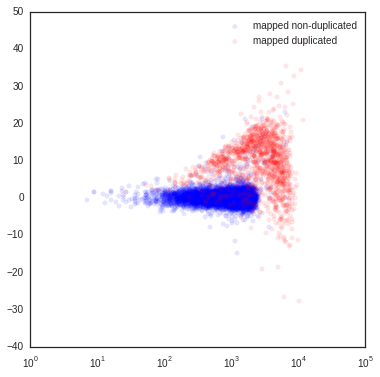

In [29]:
plt.scatter(unk['total_depth'], unk['z'], alpha = .1, color = 'green')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .1, color = 'blue')
plt.xscale('log')
plt.show()
plt.scatter(dups['total_depth'], dups['z'], alpha = .1, color = 'red')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .1, color = 'blue', label = 'mapped non-duplicated')
plt.scatter(dups['total_depth'], dups['z'], alpha = .1, color = 'red', label = 'mapped duplicated')
plt.xscale('log')
plt.legend()
plt.show()

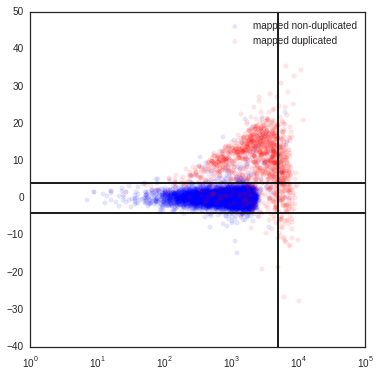

In [30]:
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .1, color = 'blue', label = 'mapped non-duplicated')
plt.scatter(dups['total_depth'], dups['z'], alpha = .1, color = 'red', label = 'mapped duplicated')
plt.xscale('log')
#plt.xlim(0, 6000)
#plt.ylim(-10, 10)
plt.axvline(5000, color = 'black')
plt.axhline(4, color = 'black')
plt.axhline(-4, color = 'black')
plt.legend()
plt.show()

In [31]:
len(non_dups)

len(non_dups[(np.abs(non_dups['z']) < 4) & (np.abs(non_dups['total_depth']) < 5000)]['locus_ID'])

6832

Before

In [32]:
print len(depths)
depths['Duplicate'].value_counts()

19061


0    10807
1     6977
2     1277
dtype: int64

After

In [33]:
center_loci = depths[(np.abs(depths['z']) < 4) & (np.abs(depths['total_depth']) < 5000)]
print len(center_loci)

print center_loci['Duplicate'].value_counts()

center_loci['locus_ID'].to_csv(os.path.join('..', 'data', 'chinook_center_loci.txt'), index = False)

16225
0    9254
1    6832
2     139
dtype: int64


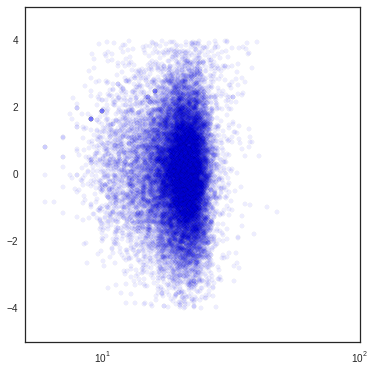

In [34]:
plt.scatter(center_loci['depth_per_het'], center_loci['z'], alpha = .07)
plt.xscale('log')
plt.xlim(5)
plt.show()

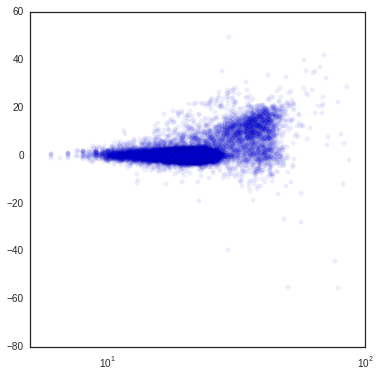

In [35]:
plt.scatter(depths['depth_per_het'], depths['z'], alpha = .07)
plt.xscale('log')
plt.xlim(5)
plt.show()

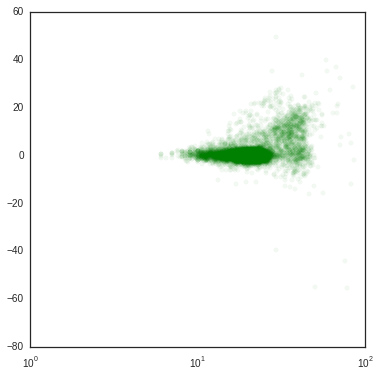

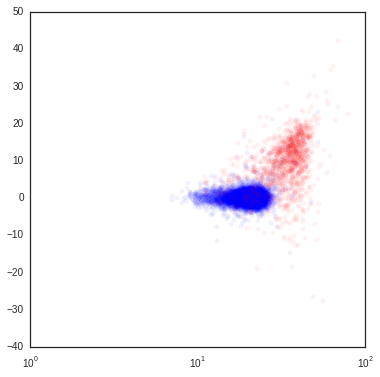

In [36]:
plt.scatter(unk['depth_per_het'], unk['z'], alpha = .05, color = 'green')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['depth_per_het'], non_dups['z'], alpha = .05, color = 'blue')
plt.scatter(dups['depth_per_het'], dups['z'], alpha = .05, color = 'red')
plt.xscale('log')
plt.show()

In [37]:
depths.head(1)

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077,3.586666


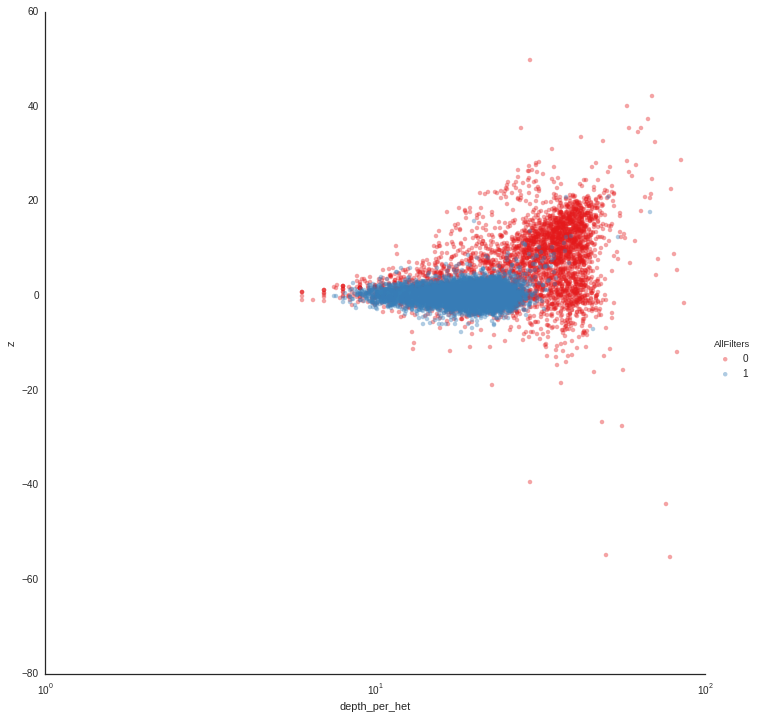

In [38]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = depths, fit_reg = False, hue = 'AllFilters', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.4}, size =10)
plt.xscale('log')

plt.show()

In [39]:
depths.head(1)

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077,3.586666


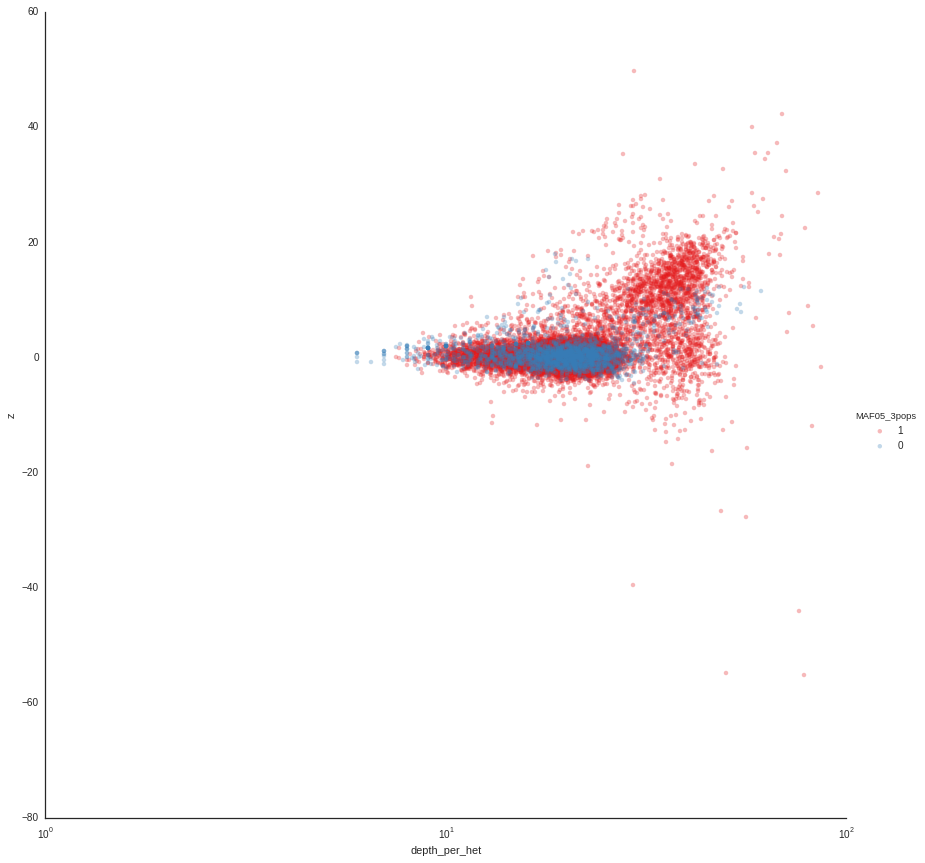

In [40]:
figsize(8,8)
sns.lmplot(x = 'depth_per_het', y = 'z', data = depths, fit_reg = False, hue = 'MAF05_3pops', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.3}, size =12)
plt.xscale('log')

plt.show()

No clear pattern of depth by position, maybe a slight trend down near the end of the reads.

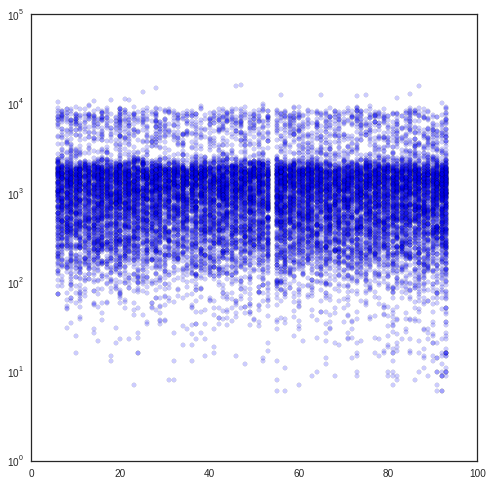

In [42]:
plt.scatter(depths['pos'], depths['total_depth'], alpha = .2)
plt.yscale('log')
plt.show()

How is the z-score related to the allelic ratio?

Bias by position

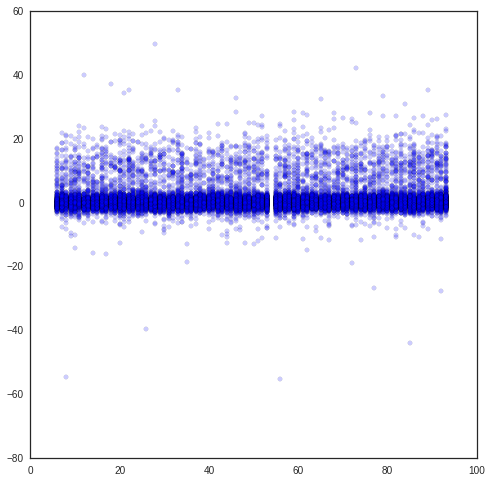

In [44]:
plt.scatter(depths['pos'], depths['z'], alpha = .2)
plt.show()

Relation to depth

#### qq plots

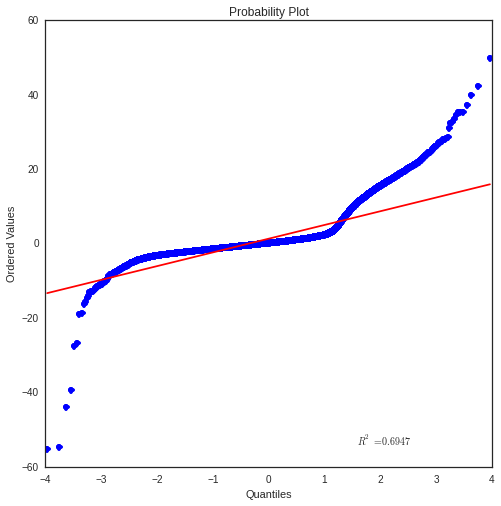

In [45]:
scipy.stats.probplot(depths['z'], dist="norm", plot=plt)
plt.show()

(-5, 5)

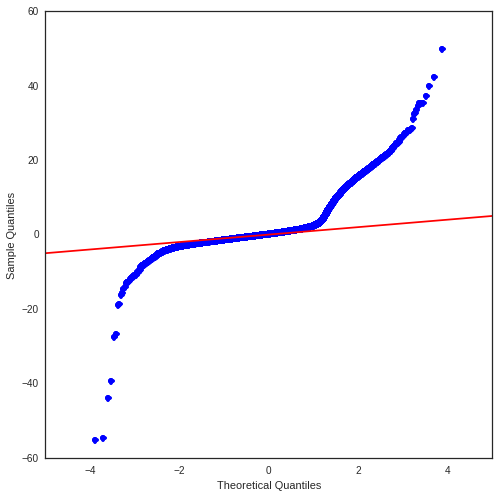

In [47]:
import statsmodels.graphics.gofplots
qq = statsmodels.graphics.gofplots.qqplot(depths['z'], line = '45')
plt.xlim(-5,5)

# BELOW IN PROGRESS

Supervised classification - can we use the mapped loci to predict the characteristics of duplicated loci?

In [48]:
depths.head(1)

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077,3.586666


In [49]:
training_loci = depths[depths['Duplicate'] > 0].copy()
training_loci['abs_z'] = np.abs(training_loci['z'])
len(training_loci)

8254

In [50]:
unknown_loci = depths[depths['Duplicate'] == 0].copy()
unknown_loci['abs_z'] = np.abs(unknown_loci['z'])
len(unknown_loci)

10807

In [51]:
training_loci = training_loci[['contig', 'pos', 'locus_ID', 'depth_a', 'depth_b', 'ratio', 'num_hets', 
               'total_depth', 'depth_per_het', 'Duplicate', 'std', 'z', 'abs_z']]
training_loci.to_csv(os.path.join('..', 'data', 'chinook.training.txt'), sep = '\t', index = False)

In [52]:
unknown_loci = unknown_loci[['contig', 'pos', 'locus_ID', 'depth_a', 'depth_b', 'ratio', 'num_hets', 
               'total_depth', 'depth_per_het', 'Duplicate', 'std', 'z', 'abs_z']]
unknown_loci.to_csv(os.path.join('..', 'data', 'chinook.unknown.txt'), sep = '\t', index = False)

### Features are possibly informative about duplicate status

In [53]:
features_list = ['depth_per_het', 'abs_z']
features = training_loci[features_list].values

In [54]:
training_loci.head()

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,std,z,abs_z
2,un,17,14,36,60,0.375000,5,96,19.200000,1,4.898979,-2.449490,2.449490
3,un,69,15,3746,2752,0.576485,184,6498,35.315217,2,40.305087,12.330950,12.330950
5,un,93,20,562,621,0.475063,47,1183,25.170213,1,17.197384,-1.715377,1.715377
7,un,47,28,782,705,0.525891,73,1487,20.369863,1,19.280819,1.996803,1.996803
8,un,80,34,383,366,0.511348,35,749,21.400000,1,13.683932,0.621166,0.621166


### Select a classifier
this is the type of algorithm to use for classification

lets try different options and compare

see [scikit learn docs](http://scikit-learn.org/dev/modules/ensemble.html)

In [55]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

# Gradient boosting classifier

In [56]:
gb_classifier = GradientBoostingClassifier(verbose=0)
gb_classifier.fit(training_loci[features_list], training_loci['Duplicate'])
gb_predictions = gb_classifier.predict(unknown_loci[features_list])
unknown_loci['gb_predictions'] = gb_predictions

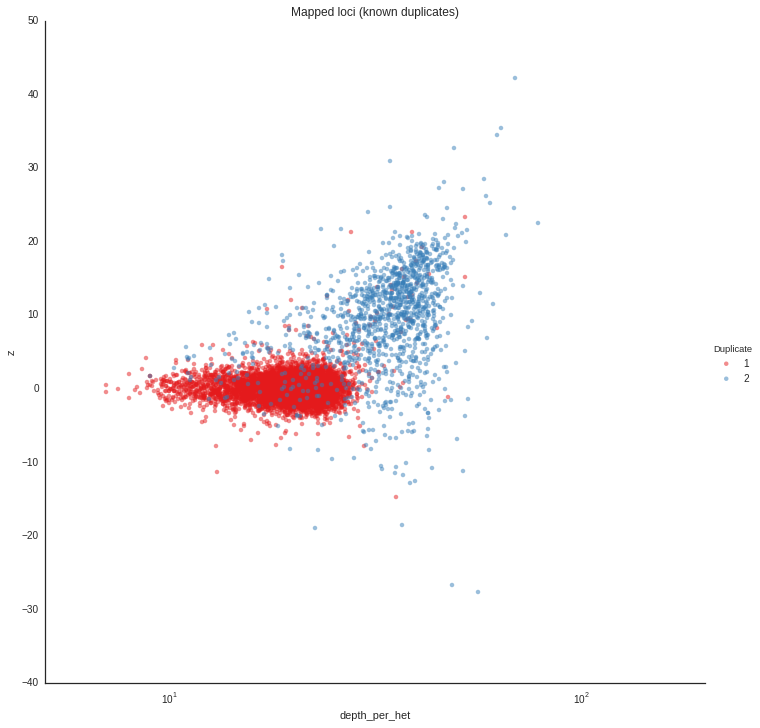

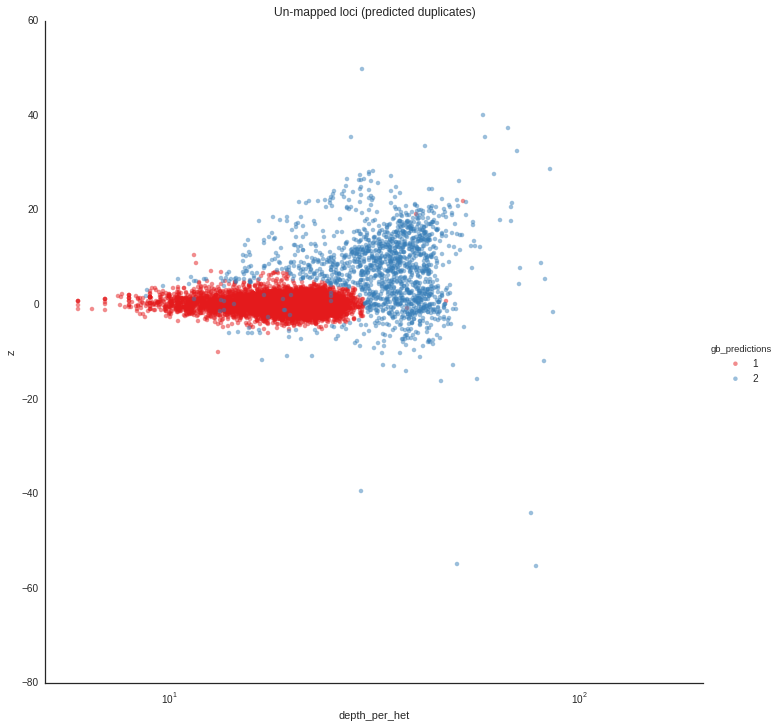

In [57]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = training_loci, fit_reg = False, hue = 'Duplicate', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Mapped loci (known duplicates)')

sns.lmplot(x = 'depth_per_het', y = 'z', data = unknown_loci, fit_reg = False, hue = 'gb_predictions', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Un-mapped loci (predicted duplicates)')
plt.show()

# ExtraTrees Classifier

In [58]:
et_classifier = ExtraTreesClassifier(n_jobs=5, n_estimators = 200, bootstrap=True,
                                     criterion = 'entropy', min_samples_split = 5, max_features=2)
et_classifier.fit(training_loci[features_list], training_loci['Duplicate'])
et_predictions = et_classifier.predict(unknown_loci[features_list])
unknown_loci['et_predictions'] = et_predictions

et_classifier.feature_importances_

array([ 0.41352274,  0.58647726])

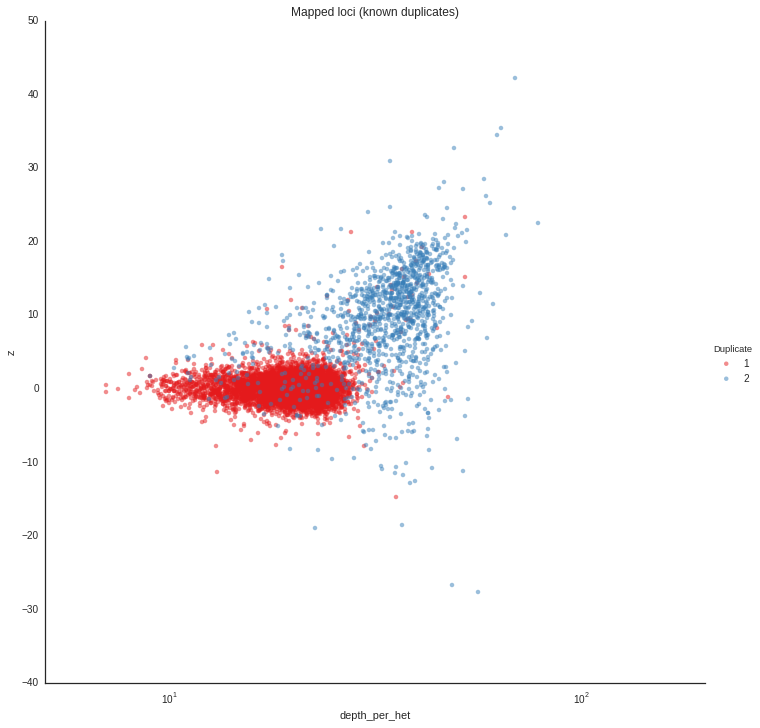

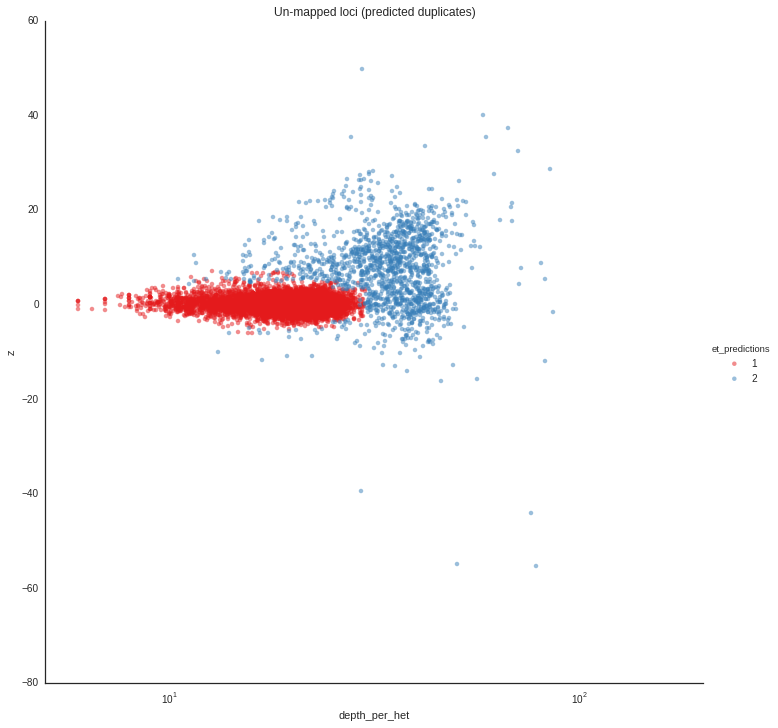

In [59]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = training_loci, fit_reg = False, hue = 'Duplicate', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Mapped loci (known duplicates)')

sns.lmplot(x = 'depth_per_het', y = 'z', data = unknown_loci, fit_reg = False, hue = 'et_predictions', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Un-mapped loci (predicted duplicates)')
plt.show()

In [60]:
pd.crosstab(training_loci['Duplicate'], et_classifier.predict(training_loci[features_list]), rownames=["Actual"], colnames=["Pred"])

Pred,1,2
Actual,,
1,6906,71
2,90,1187


## Bagging classifier

In [61]:
bag_classifier = BaggingClassifier(n_jobs=5, max_samples = .2, n_estimators = 500)
bag_classifier.fit(training_loci[features_list], training_loci['Duplicate'])
bag_predictions = bag_classifier.predict(unknown_loci[features_list])
unknown_loci['bag_predictions'] = bag_predictions

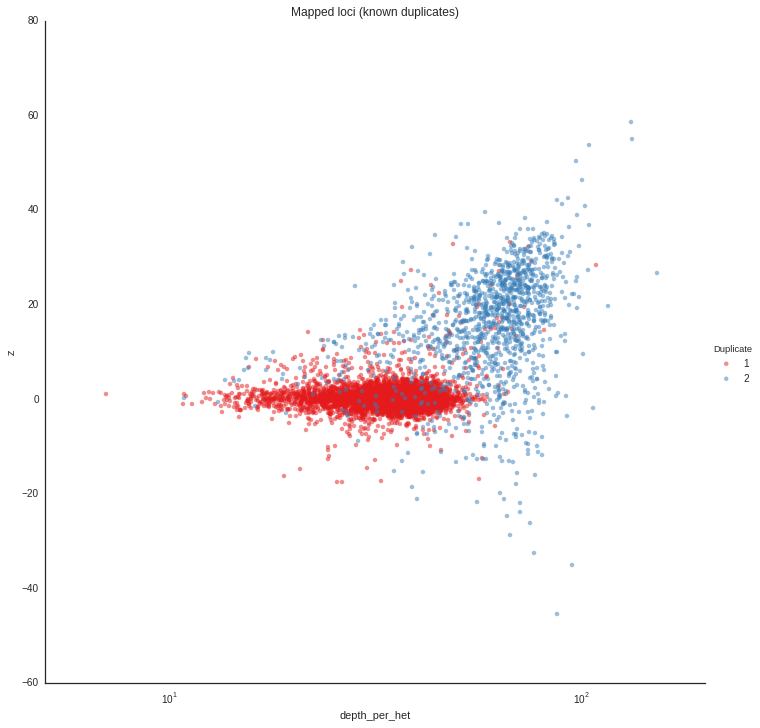

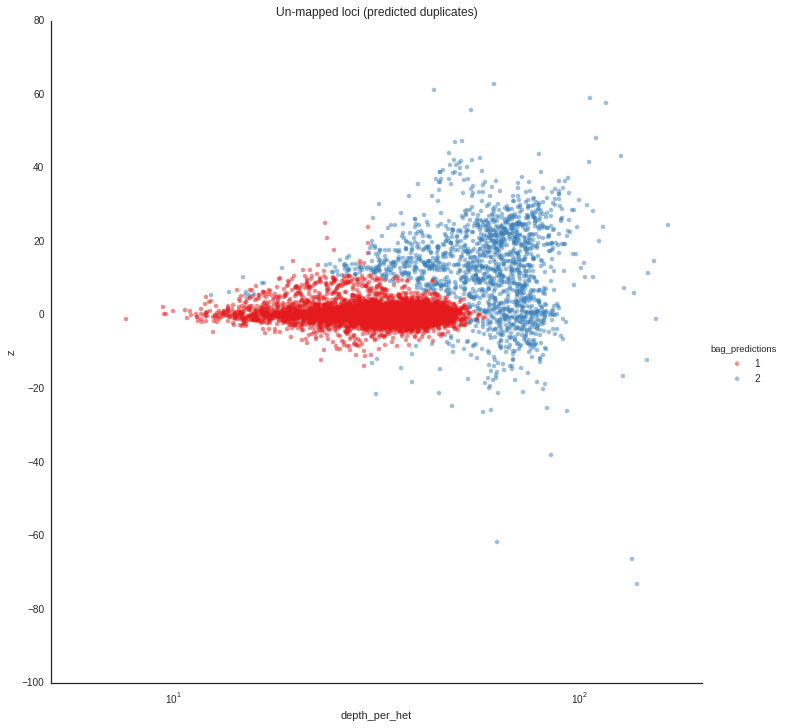

In [182]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = training_loci, fit_reg = False, hue = 'Duplicate', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Mapped loci (known duplicates)')

sns.lmplot(x = 'depth_per_het', y = 'z', data = unknown_loci, fit_reg = False, hue = 'bag_predictions', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Un-mapped loci (predicted duplicates)')
plt.show()

In [194]:
pd.crosstab(training_loci['Duplicate'], bag_classifier.predict(training_loci[features_list]), rownames=["Actual"], colnames=["Pred"])

Pred,1,2
Actual,,
1,6978,92
2,100,1183


## Ada boost classifier

In [65]:
ada_classifier = AdaBoostClassifier(n_estimators=100)
ada_classifier.fit(training_loci[features_list], training_loci['Duplicate'])
ada_predictions = ada_classifier.predict(unknown_loci[features_list])
unknown_loci['ada_predictions'] = ada_predictions
ada_classifier.feature_importances_

array([ 0.51,  0.49])

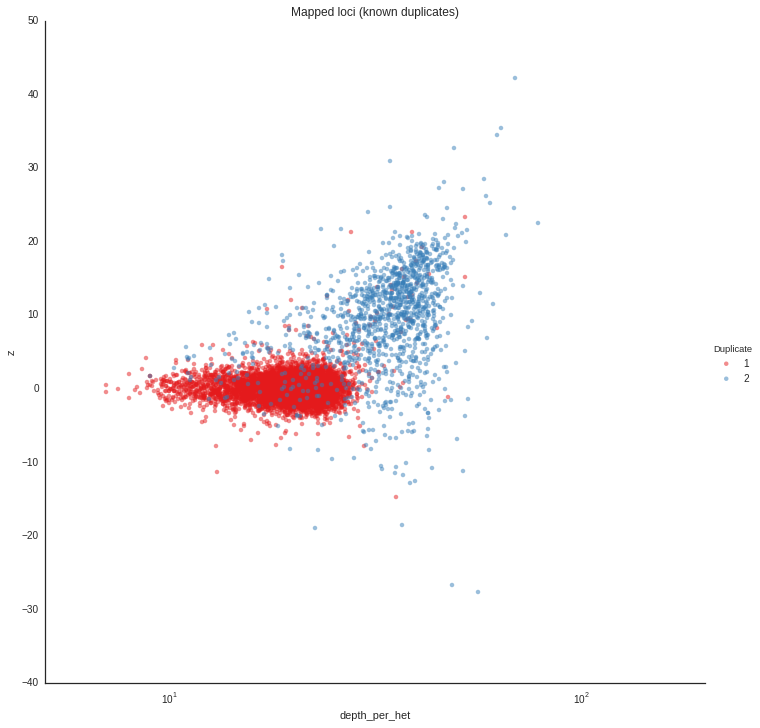

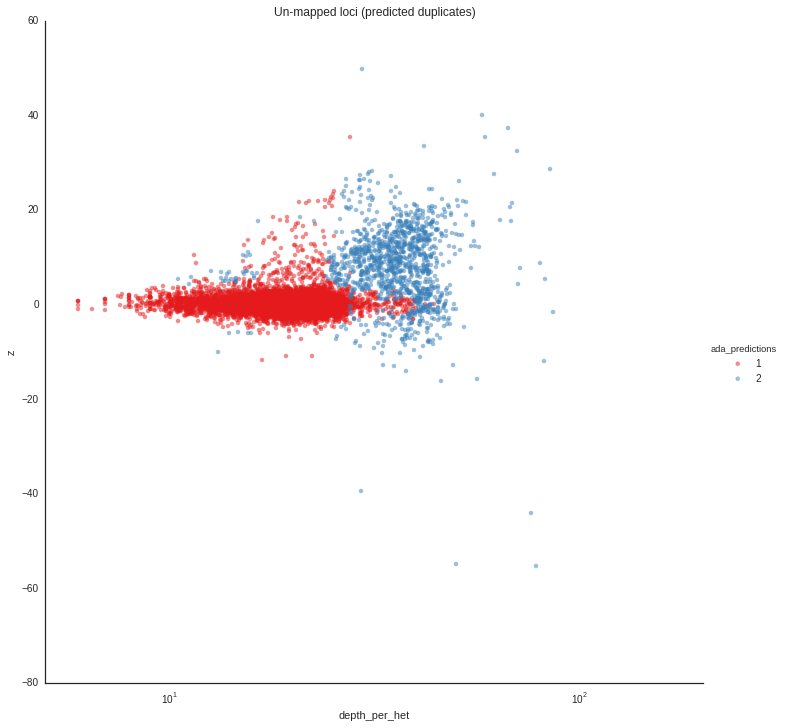

In [66]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = training_loci, fit_reg = False, hue = 'Duplicate', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Mapped loci (known duplicates)')

sns.lmplot(x = 'depth_per_het', y = 'z', data = unknown_loci, fit_reg = False, hue = 'ada_predictions', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Un-mapped loci (predicted duplicates)')
plt.show()

In [67]:
pd.crosstab(training_loci['Duplicate'], ada_classifier.predict(training_loci[features_list]), rownames=["Actual"], colnames=["Pred"])

Pred,1,2
Actual,,
1,6909,68
2,228,1049


## random forests

notice the apparent overfitting

min_samples_split = 5, min_samples_leaf = 5

In [68]:
rf_classifier = RandomForestClassifier(n_estimators = 200, n_jobs=5)
rf_classifier.fit(training_loci[features_list], training_loci['Duplicate'])
rf_predictions = rf_classifier.predict(unknown_loci[features_list])
unknown_loci['rf_predictions'] = rf_predictions

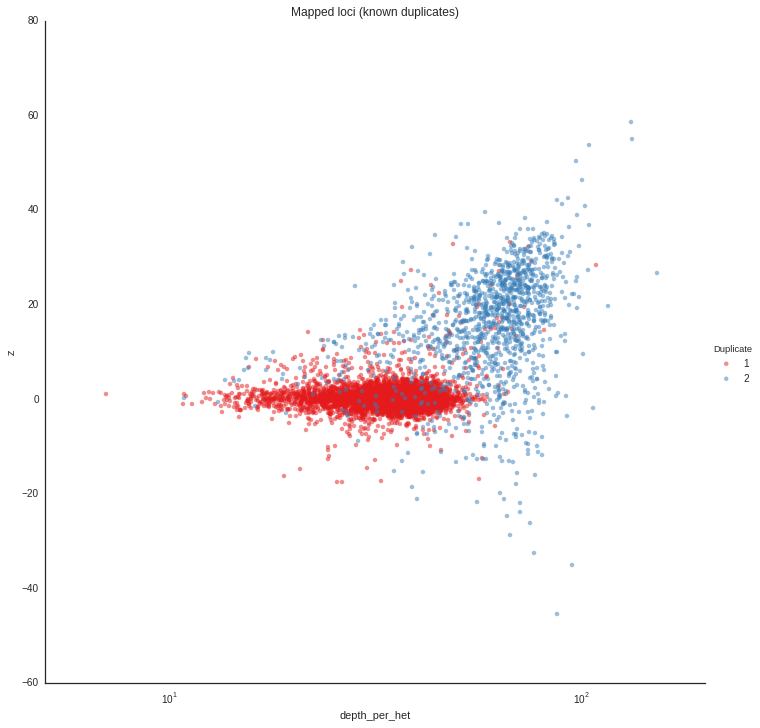

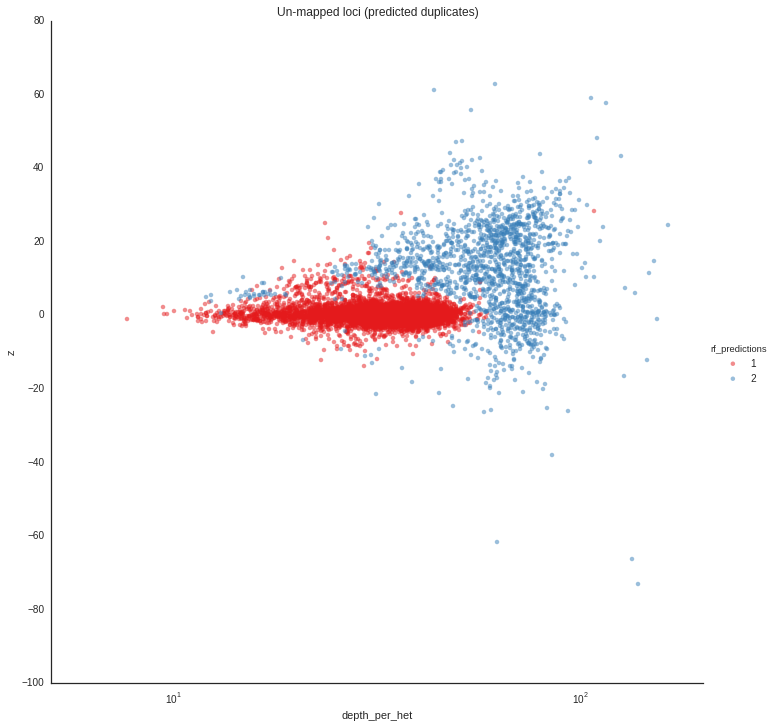

In [230]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = training_loci, fit_reg = False, hue = 'Duplicate', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Mapped loci (known duplicates)')

sns.lmplot(x = 'depth_per_het', y = 'z', data = unknown_loci, fit_reg = False, hue = 'rf_predictions', 
          palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.5}, size =10)
plt.xscale('log')
plt.xlim(5, 200)
plt.title('Un-mapped loci (predicted duplicates)')
plt.show()

In [212]:
pd.crosstab(training_loci['Duplicate'], rf_classifier.predict(training_loci[features_list]), rownames=["Actual"], colnames=["Pred"])

Pred,1,2
Actual,,
1,7070,0
2,0,1283


### Crossvalidation


This is done with milk, see the documentation [here](https://pythonhosted.org/milk/nfoldcrossvalidation.html)

default 10-fold stratified cross validation

combined across studies - could use different 'origins' 

In [ ]:
cmat, names, preds = milk.nfoldcrossvalidation(features, labels, learner=classifier, return_predictions=1, nfolds = 10)

parse the confusion matrix

TODO: turn this into a general function

In [87]:
true_postive = cmat[1,1]
true_negative = cmat[0,0]
false_postive = cmat[0,1]
false_negative = cmat[1,0]
condition_positive = cmat[1,:]
condition_negative = cmat[0,:]
test_outcome_positive = cmat[:,1]
test_outcome_negative = cmat[:,0]

NameError: name 'cmat' is not defined

In [ ]:
print 'prevalence:', condition_positive.sum()/cmat.sum()

print 'accuracy:', (true_postive+true_negative)/float(cmat.sum())
print 'sensitivity:', true_postive/condition_positive.sum()
print 'specificty:', true_negative/condition_negative.sum()
print 'precision:', true_postive/test_outcome_positive.sum()
print 'FDR:', false_postive/test_outcome_positive.sum()

In [ ]:
sns.heatmap(cmat, annot = True, fmt = '.5g', annot_kws = {'fontsize': '44'}, cbar = False, vmin =0, vmax =0, linewidths = 5, linecolor='black')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

We could extend this - currently just classifying duplicates, can we extend to classify 'good loci'

# End machine learning

#### This will write out depth per locus per individual

In [69]:
from vcf_to_depth import vcf_to_allele_depth_by_ind

In [70]:
vcf_file = os.path.join('..', 'data', 'chinook.bay_pops.vcf.gz')
depths_file = os.path.join('..', 'data', 'chinook.bay_pops.depths_by_ind')

In [71]:
vcf_to_allele_depth_by_ind(vcf_file=vcf_file, out_file = depths_file)

skipped 9 header lines
found 192 individuals


In [72]:
ind_depths = pd.read_csv(depths_file, sep = '\t', header = None)
ind_depths.columns = ['contig', 'pos', 'locus_ID', 'ind', 'depth_a' , 'depth_b', 'std', 'z']
ind_depths['depth'] = ind_depths['depth_a'] + ind_depths['depth_b']
ind_depths['abs_z'] = np.abs(ind_depths['z'])
ind_depths.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z
0,un,44,10,KKANE05_0002,3,2,1.118034,0.447214,5,0.447214
1,un,44,10,KKANE05_0003,6,5,1.658312,0.301511,11,0.301511
2,un,44,10,KKANE05_0004,12,4,2.000000,2.000000,16,2.000000
3,un,44,10,KKANE05_0005,8,12,2.236068,-0.894427,20,0.894427
4,un,44,10,KKANE05_0012,21,5,2.549510,3.137858,26,3.137858


### merge duplicated loci

In [73]:
duplicate_status = pd.read_csv(os.path.join('..', 'data', 'chinook_DuplicateStatus.txt'), sep = '\t', header = 0)
duplicate_status.columns = ['locus_ID', 'Duplicate']
ind_depths = pd.merge(ind_depths, duplicate_status)
ind_depths.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z,Duplicate
0,un,44,10,KKANE05_0002,3,2,1.118034,0.447214,5,0.447214,0
1,un,44,10,KKANE05_0003,6,5,1.658312,0.301511,11,0.301511,0
2,un,44,10,KKANE05_0004,12,4,2.000000,2.000000,16,2.000000,0
3,un,44,10,KKANE05_0005,8,12,2.236068,-0.894427,20,0.894427,0
4,un,44,10,KKANE05_0012,21,5,2.549510,3.137858,26,3.137858,0


In [74]:
ind_depth_means = ind_depths.groupby('ind').mean()

ind_depth_means.head()
ind_depth_means['pop'] = [xx.split('_')[0] for xx in ind_depth_means.index.tolist()]

In [75]:
set(ind_depth_means['pop'])

{'KAROL05', 'KGEOR05', 'KKANE05', 'KKISA05'}

In [96]:
ind_depth_means.groupby('pop')['depth'].value_counts()

pop               
KAROL05  19.817901    1
         29.591315    1
         28.680132    1
         28.870046    1
         26.297747    1
         29.166276    1
         29.635856    1
         26.412894    1
         24.800929    1
         30.108265    1
         27.495037    1
         27.329279    1
         27.053186    1
         31.420606    1
         29.410465    1
         27.691147    1
         27.792723    1
         26.110006    1
         31.545016    1
         29.164518    1
         28.015862    1
         28.692033    1
         27.332632    1
         18.802684    1
         26.320912    1
         30.750663    1
         33.283309    1
         26.156827    1
         28.101301    1
         28.394428    1
                     ..
KKISA05  22.053858    1
         37.742021    1
         28.352535    1
         24.296338    1
         30.519430    1
         28.545715    1
         29.826328    1
         29.018552    1
         31.177358    1
         26.332335   

In [78]:
depths.head(1)

,contig,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,44,10,1181,1013,0.538286,112,2194,19.589286,0,1,0,0,1,1,0,0,23.420077,3.586666


In [79]:
ind_depths = pd.merge(ind_depths, filter_sets)
ind_depths.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,un,44,10,KKANE05_0002,3,2,1.118034,0.447214,5,0.447214,0,1,0,0,1,1,0,0
1,un,44,10,KKANE05_0003,6,5,1.658312,0.301511,11,0.301511,0,1,0,0,1,1,0,0
2,un,44,10,KKANE05_0004,12,4,2.000000,2.000000,16,2.000000,0,1,0,0,1,1,0,0
3,un,44,10,KKANE05_0005,8,12,2.236068,-0.894427,20,0.894427,0,1,0,0,1,1,0,0
4,un,44,10,KKANE05_0012,21,5,2.549510,3.137858,26,3.137858,0,1,0,0,1,1,0,0


In [80]:
ind_depths_pass =  ind_depths[[xx == 1 for xx in ind_depths['AllFilters']]]
ind_depths_pass.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
119,un,17,14,KKANE05_0079,7,2,1.500000,1.666667,9,1.666667,1,1,1,1,1,1,1,1
120,un,17,14,KGEOR05_0051,8,12,2.236068,-0.894427,20,0.894427,1,1,1,1,1,1,1,1
121,un,17,14,KGEOR05_0726,10,12,2.345208,-0.426401,22,0.426401,1,1,1,1,1,1,1,1
122,un,17,14,KAROL05_0015,5,18,2.397916,-2.710687,23,2.710687,1,1,1,1,1,1,1,1
123,un,17,14,KKISA05_0022,6,16,2.345208,-2.132007,22,2.132007,1,1,1,1,1,1,1,1


In [81]:
ind_depth_pass_means = ind_depths_pass.groupby('ind').mean()
ind_depth_pass_means['pop'] = [xx.split('_')[0] for xx in ind_depth_pass_means.index.tolist()]

In [82]:
ind_depth_pass_means.head()

,pos,locus_ID,depth_a,depth_b,std,z,depth,abs_z,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,pop
ind,,,,,,,,,,,,,,,,,
KAROL05_0001,50.625905,46098.953482,10.796936,10.800000,2.287646,-0.004256,21.596936,1.078759,0.484680,1,1,1,1,1,1,1,KAROL05
KAROL05_0002,49.271800,46324.792326,11.243896,11.180843,2.327711,0.007760,22.424738,1.104187,0.489938,1,1,1,1,1,1,1,KAROL05
KAROL05_0003,50.138845,46566.424483,10.918919,10.782459,2.293496,0.029325,21.701378,1.052455,0.492581,1,1,1,1,1,1,1,KAROL05
KAROL05_0004,49.847642,46312.658188,11.861420,11.758082,2.390251,0.015014,23.619502,1.071612,0.492316,1,1,1,1,1,1,1,KAROL05
KAROL05_0005,50.009119,46554.340021,12.392913,12.260292,2.443214,0.021552,24.653205,1.108298,0.487493,1,1,1,1,1,1,1,KAROL05


In [83]:
ind_depth_pass_means['combo'] = ['combo' in xx for xx in ind_depth_pass_means.index.tolist()]

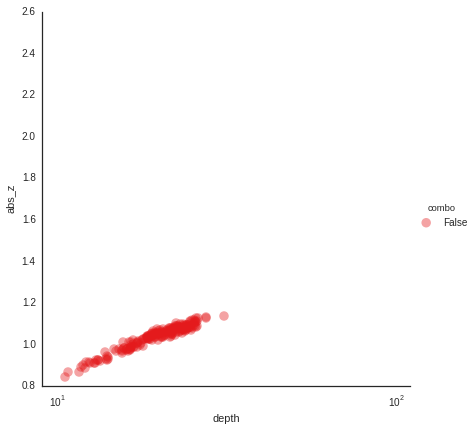

In [84]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_pass_means, fit_reg = False, hue = 'combo', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.4, 's':90}, size =6)
plt.xlim(9, 110)
plt.ylim(.8, 2.6)
plt.xscale('log')

plt.show()

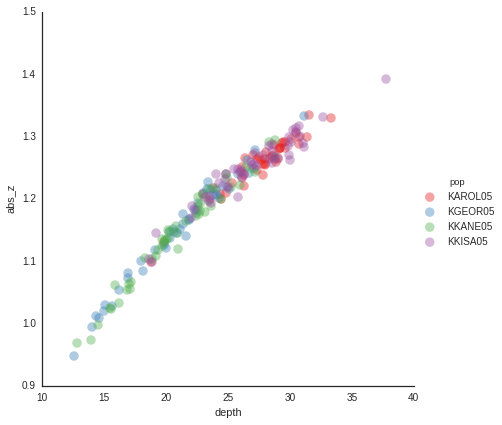

In [86]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_means, fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.4, 's':90}, size =6)
plt.show()

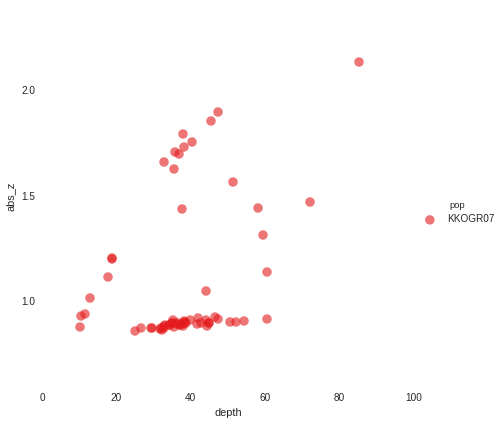

In [225]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_pass_means[ind_depth_means['pop']== 'KKOGR07'], fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.6, 's':90}, size =6)
plt.show()

In [234]:
KKOGR = ind_depth_pass_means[ind_depth_pass_means['pop']=='KKOGR07'] 
KKOGR = KKOGR[KKOGR['depth'] > 21]
len(KKOGR)

57

In [236]:
lows = KKOGR[KKOGR['abs_z'] < 1]
lows = lows[lows['depth'] > 20]
len(lows)

40

In [242]:
lows.index.tolist()

['KKOGR07_0006',
 'KKOGR07_0007',
 'KKOGR07_0008',
 'KKOGR07_0009',
 'KKOGR07_0013',
 'KKOGR07_0014',
 'KKOGR07_0018',
 'KKOGR07_0019',
 'KKOGR07_0021',
 'KKOGR07_0023',
 'KKOGR07_0024',
 'KKOGR07_0029',
 'KKOGR07_0031',
 'KKOGR07_0035',
 'KKOGR07_0037',
 'KKOGR07_0038',
 'KKOGR07_0039',
 'KKOGR07_0040',
 'KKOGR07_0041',
 'KKOGR07_0044',
 'KKOGR07_0045',
 'KKOGR07_0046',
 'KKOGR07_0047',
 'KKOGR07_0048',
 'KKOGR07_0049',
 'KKOGR07_0050',
 'KKOGR07_0051',
 'KKOGR07_0052',
 'KKOGR07_0053',
 'KKOGR07_0054',
 'KKOGR07_0055',
 'KKOGR07_0056',
 'KKOGR07_0057',
 'KKOGR07_0058',
 'KKOGR07_0059',
 'KKOGR07_0060',
 'KKOGR07_0061',
 'KKOGR07_0062',
 'KKOGR07_0063',
 'KKOGR07_0064']

In [239]:
highs = KKOGR[KKOGR['abs_z'] > 1.5]
len(highs)

11

In [241]:
highs.index.tolist()

['KKOGR07_0017',
 'KKOGR07_0022',
 'KKOGR07_0025_combo',
 'KKOGR07_0027',
 'KKOGR07_0028',
 'KKOGR07_0030',
 'KKOGR07_0032',
 'KKOGR07_0033',
 'KKOGR07_0034',
 'KKOGR07_0036',
 'KKOGR07_0042']

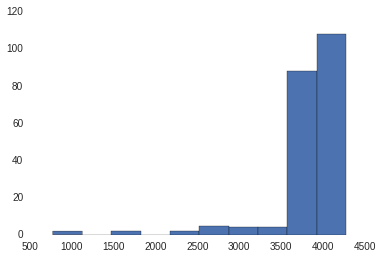

In [193]:
ind_depth_pass_counts = ind_depths_pass.groupby('ind').count()

ind_depth_pass_counts['abs_z'].hist()

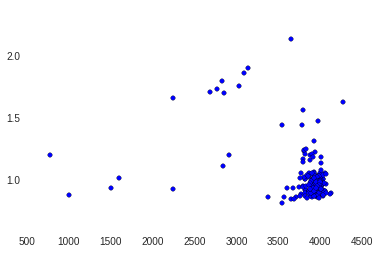

In [191]:
plt.scatter(x = ind_depth_pass_counts['abs_z'], y = ind_depth_pass_means['abs_z'])

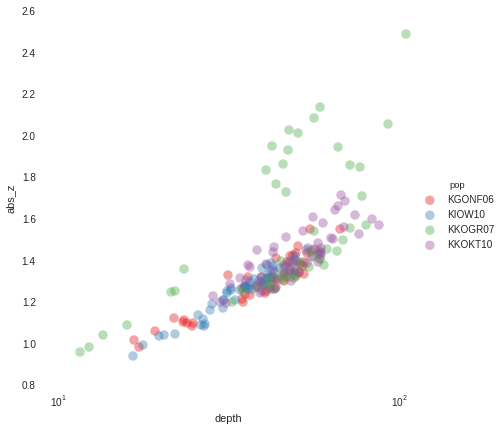

In [153]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_means, fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.4, 's':90}, size =6)
plt.xlim(9, 110)
plt.ylim(.8, 2.6)
plt.xscale('log')

plt.show()

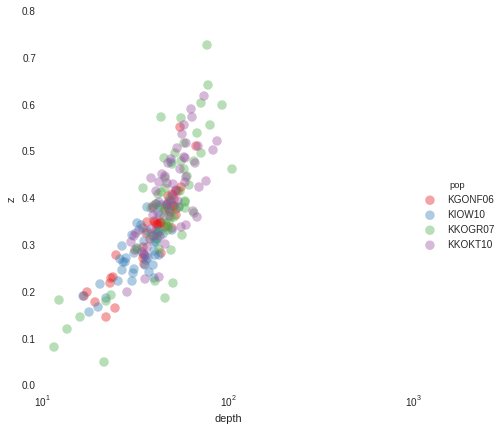

In [157]:
sns.lmplot(x = 'depth', y = 'z', data = ind_depth_means, fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.4, 's':90}, size =6)

plt.xscale('log')

plt.show()

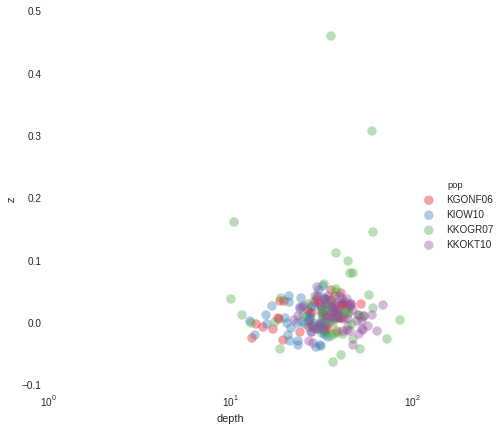

In [158]:
sns.lmplot(x = 'depth', y = 'z', data = ind_depth_pass_means, fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.4, 's':90}, size =6)

plt.xscale('log')

plt.show()

# groupby locus

In [62]:
ind_depth_means = ind_depths.groupby('locus_ID').mean()

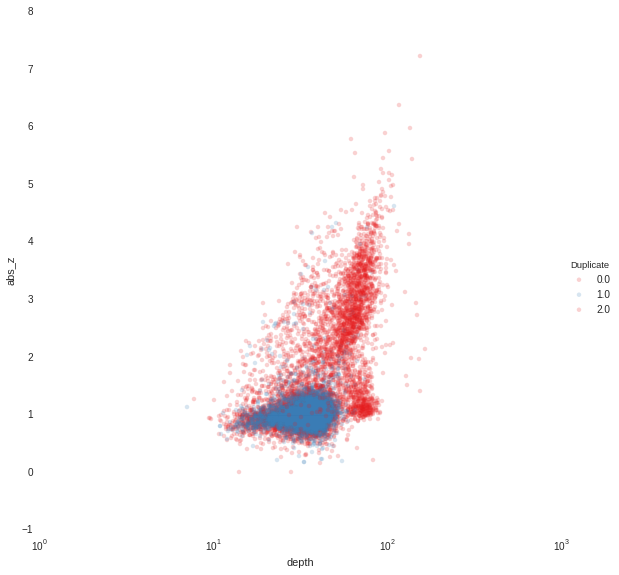

In [64]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_means, fit_reg = False, hue = 'Duplicate', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.2}, size =8)
plt.xscale('log')

plt.show()